In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# Define paths
data_dir = "Data"

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 (required for BEiT)
    transforms.ToTensor(),         # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load the dataset using ImageFolder
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Print the class-to-index mapping
print("Class-to-Index Mapping:", full_dataset.class_to_idx)

# Split into train and validation sets
train_idx, val_idx = train_test_split(range(len(full_dataset)), test_size=0.2, stratify=full_dataset.targets)

# Subset the dataset for training and validation
train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")


Class-to-Index Mapping: {'Informative': 0, 'Non_Informative': 1}
Training set size: 3410
Validation set size: 853


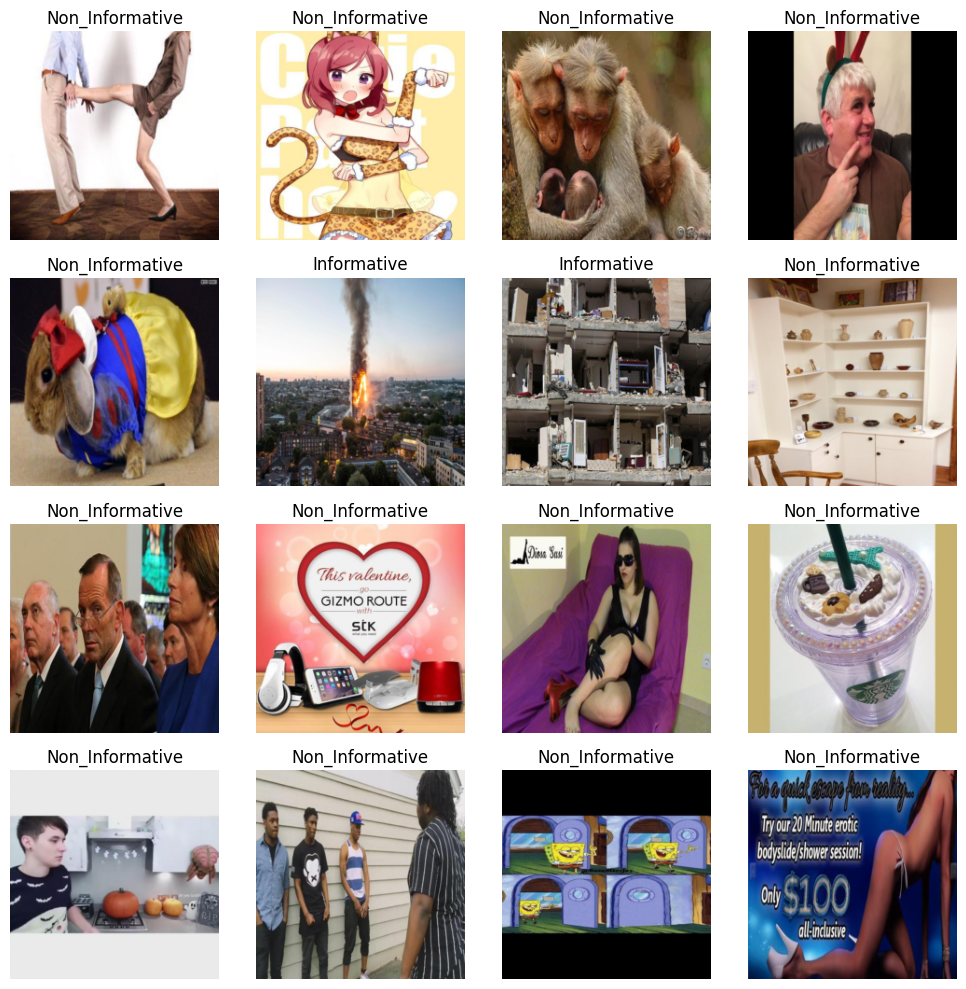

In [2]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Define paths
data_dir = "Data"

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),         # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load the dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split into train and validation sets
train_idx, val_idx = train_test_split(range(len(full_dataset)), test_size=0.2, stratify=full_dataset.targets)
train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Function to denormalize and display images
def denormalize(img_tensor):
    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])
    return img_tensor * std[:, None, None] + mean[:, None, None]

def show_batch(dataloader):
    # Get one batch of data
    images, labels = next(iter(dataloader))
    
    # Denormalize and convert to NumPy for visualization
    images = [denormalize(img).permute(1, 2, 0).numpy() for img in images]
    labels = labels.numpy()

    # Create a grid to display images
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()
    
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(full_dataset.classes[label])
    
    plt.tight_layout()
    plt.show()

# Show a batch from the training data
show_batch(train_loader)


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Train Acc: 0.8326, Val Acc: 0.8617
Epoch 2/5, Train Acc: 0.8815, Val Acc: 0.8640
Epoch 3/5, Train Acc: 0.9311, Val Acc: 0.8863
Epoch 4/5, Train Acc: 0.9416, Val Acc: 0.8675
Epoch 5/5, Train Acc: 0.9672, Val Acc: 0.8687


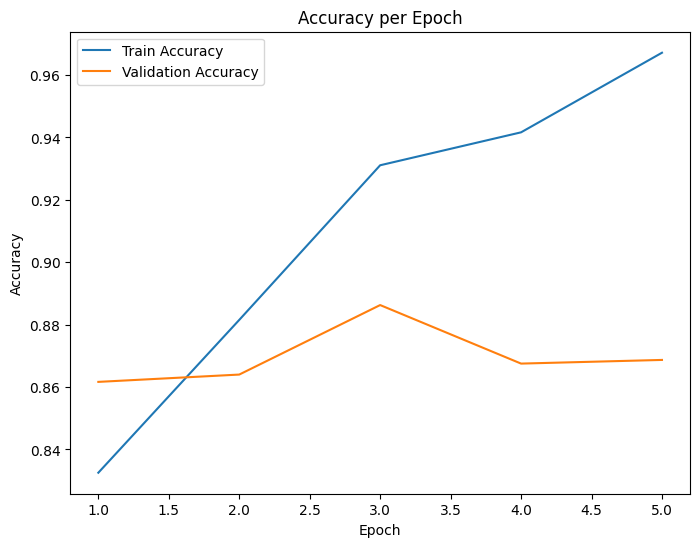

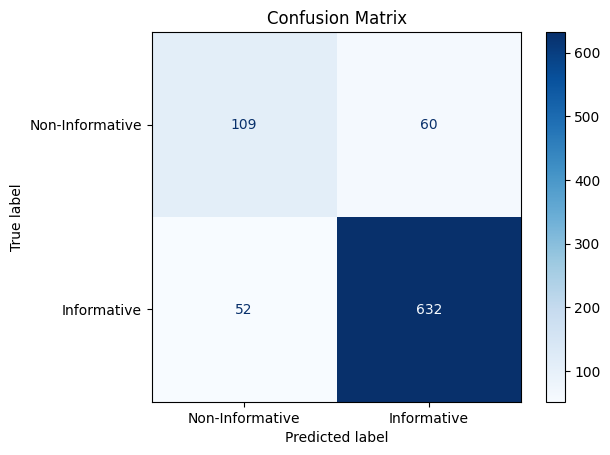

In [5]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import BeitForImageClassification
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths
data_dir = "Data"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split dataset
train_idx, val_idx = train_test_split(range(len(full_dataset)), test_size=0.2, stratify=full_dataset.targets)
train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load pre-trained BEiT model with ignore_mismatched_sizes=True
model = BeitForImageClassification.from_pretrained(
    "microsoft/beit-base-patch16-224", 
    num_labels=2,  # Informative and Non-Informative
    ignore_mismatched_sizes=True  # Ignore mismatched sizes for the classifier layer
)
model.to(device)

# Optional: Explicitly reinitialize the classifier layer
from torch.nn import Linear
model.classifier = Linear(model.config.hidden_size, 2)
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 5
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    train_preds = []
    train_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_accuracy = accuracy_score(train_labels, train_preds)
    train_acc_history.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    val_acc_history.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

# Plot accuracy per epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_history, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Informative', 'Informative'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



Model saved to beit_model.pth
Classification Report:
                 precision    recall  f1-score   support

    Informative       0.68      0.64      0.66       169
Non_Informative       0.91      0.92      0.92       684

       accuracy                           0.87       853
      macro avg       0.80      0.78      0.79       853
   weighted avg       0.87      0.87      0.87       853



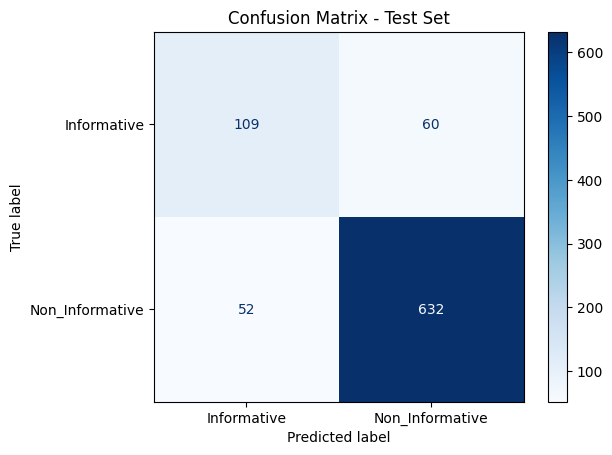

In [6]:
import os
from sklearn.metrics import classification_report

# Define paths
model_save_path = "beit_model.pth"  # Filepath to save the model

# Save the model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Test the model
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    test_preds = []
    test_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)
            
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    return test_labels, test_preds

# Assuming val_loader acts as your test_loader
test_labels, test_preds = test_model(model, val_loader)

# Generate classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=full_dataset.classes))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=full_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()
